In [25]:
#Importing essential libraries for project
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
#Base directory where 4 classes of images are stored
base_dir = "data"  

#skin aging categories
classes = ["Wrinkles", "Dark Spots", "Puffy Eyes", "Clear Skin"]

In [26]:
def build_df_from_folders(root, class_names, exts=(".jpg", ".jpeg", ".png")):
    paths, labs = [], []
    for c in class_names:
        p = os.path.join(root, c)
        if not os.path.isdir(p):
            print("Missing folder:", p)
            continue
        for f in os.listdir(p):
            if f.lower().endswith(exts):
                paths.append(os.path.join(p, f))
                labs.append(c)
    return pd.DataFrame({"filepath": paths, "label": labs})

In [27]:
#Building the dataframe
df = build_df_from_folders(base_dir, classes)

print("Total images:", len(df))
print(df["label"].value_counts())
df.head()



Total images: 1203
label
Dark Spots    303
Wrinkles      300
Puffy Eyes    300
Clear Skin    300
Name: count, dtype: int64


,filepath,label
0,data\Wrinkles\1.jpg,Wrinkles
1,data\Wrinkles\10.jpg,Wrinkles
2,data\Wrinkles\100.jpg,Wrinkles
3,data\Wrinkles\101.jpg,Wrinkles
4,data\Wrinkles\102.jpg,Wrinkles


In [28]:
df.to_csv("Module1&2_df.csv", index=False)
print("Saved Module1&2_df")


Saved Module1&2_df


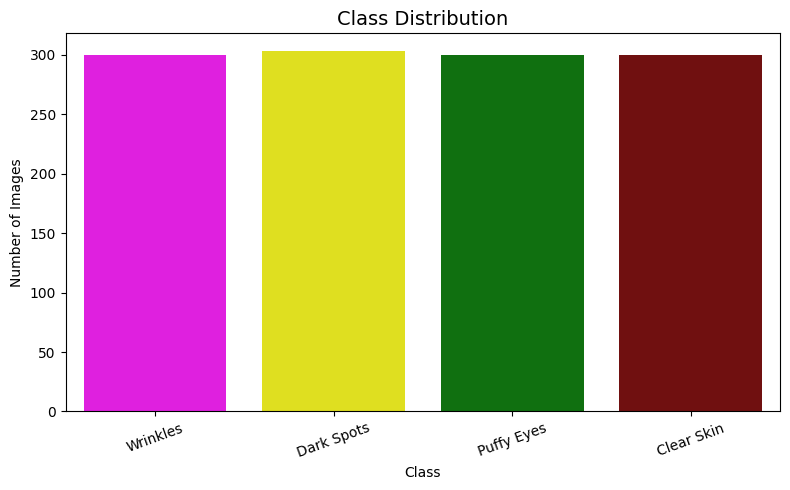

In [29]:
# Plotting how many images are present in each class
plt.figure(figsize=(8,5))

colors = ["magenta", "yellow", "green", "maroon"]

sns.countplot(
    data=df,
    x="label",
    hue="label",          
    palette=colors,
    legend=False          
)

plt.title("Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



In [30]:
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
#Import libraries for Module 2

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

#ImageDataGenerator for image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [32]:
IMG_SIZE = 224
images = []
labels_list = []

for i, row in df.iterrows():
    img_path = row["filepath"]
    label = row["label"]

    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0   # normalize
    images.append(img_array)
    labels_list.append(label)

images = np.array(images)
print("Processed images shape:", images.shape)


Processed images shape: (1203, 224, 224, 3)


In [33]:
#using ImageDataGenerator to create modified images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


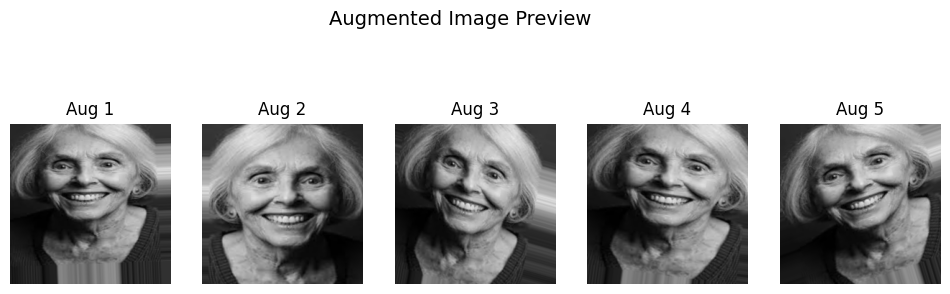

In [34]:
import random

random_index = random.randrange(len(images))
selected_image = images[random_index]

#adding extra dimension for ImageDataGenerator
image_array = np.expand_dims(selected_image, axis=0)
# We Generate 5 augmented images
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

plt.figure(figsize=(12, 4))
for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Augmented Image Preview", fontsize=14)
plt.show()


In [35]:
label_map = {
    "Clear Skin": 0,
    "Dark Spots": 1,
    "Puffy Eyes": 2,
    "Wrinkles": 3
}

df["label_id"] = df["label"].map(label_map)

labels_numeric = df["label_id"].values
labels_onehot = to_categorical(labels_numeric, num_classes=4)

print("One-hot encoded shape:", labels_onehot.shape)
print(labels_onehot[:5])


One-hot encoded shape: (1203, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_onehot,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Training shape: (962, 224, 224, 3)
Validation shape: (241, 224, 224, 3)


In [37]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_train = preprocess_input(X_train * 255.0)
X_val   = preprocess_input(X_val * 255.0)

print("MobileNetV2 preprocessing applied")


MobileNetV2 preprocessing applied


In [38]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [39]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


In [40]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "AIDermalScan_MobileNetV2_best.h5",
    monitor="val_accuracy",
    save_best_only=True
)

callbacks = [early_stop, reduce_lr, checkpoint]


In [43]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.2524 - loss: 1.7561

31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2682 - loss: 1.6516 - val_accuracy: 0.3361 - val_loss: 1.4107 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.3367 - loss: 1.4754

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 776ms/step - accuracy: 0.3669 - loss: 1.4218 - val_accuracy: 0.4481 - val_loss: 1.2454 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.4099 - loss: 1.2909

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 731ms/step - accuracy: 0.4241 - loss: 1.2527 - val_accuracy: 0.5353 - val_loss: 1.1127 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5085 - loss: 1.1763

31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 717ms/step - accuracy: 0.5281 - loss: 1.1288 - val_accuracy: 0.6266 - val_loss: 1.0120 - learning_rate: 1.0000e-04
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.5551 - loss: 1.0497

31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 720ms/step - accuracy: 0.5696 - loss: 1.0280 - val_accuracy: 0.6556 - val_loss: 0.9356 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6255 - loss: 0.9396

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 685ms/step - accuracy: 0.6195 - loss: 0.9363 - val_accuracy: 0.7012 - val_loss: 0.8740 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 667ms/step - accuracy: 0.6372 - loss: 0.8896 - val_accuracy: 0.7012 - val_loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6767 - loss: 0.8408

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 682ms/step - accuracy: 0.6674 - loss: 0.8383 - val_accuracy: 0.7178 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 9/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6753 - loss: 0.7814

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 718ms/step - accuracy: 0.6798 - loss: 0.7965 - val_accuracy: 0.7261 - val_loss: 0.7588 - learning_rate: 1.0000e-04
Epoch 10/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7003 - loss: 0.7546

31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 720ms/step - accuracy: 0.7037 - loss: 0.7668 - val_accuracy: 0.7386 - val_loss: 0.7339 - learning_rate: 1.0000e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6991 - loss: 0.7707

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 715ms/step - accuracy: 0.7089 - loss: 0.7506 - val_accuracy: 0.7427 - val_loss: 0.7127 - learning_rate: 1.0000e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 682ms/step - accuracy: 0.7432 - loss: 0.6853 - val_accuracy: 0.7427 - val_loss: 0.6960 - learning_rate: 1.0000e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7528 - loss: 0.6651

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 749ms/step - accuracy: 0.7495 - loss: 0.6754 - val_accuracy: 0.7552 - val_loss: 0.6754 - learning_rate: 1.0000e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 702ms/step - accuracy: 0.7599 - loss: 0.6418 - val_accuracy: 0.7427 - val_loss: 0.6598 - learning_rate: 1.0000e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.7692 - loss: 0.6285 - val_accuracy: 0.7552 - val_loss: 0.6438 - learning_rate: 1.0000e-04
Epoch 16/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7515 - loss: 0.6348

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 685ms/step - accuracy: 0.7609 - loss: 0.6162 - val_accuracy: 0.7635 - val_loss: 0.6303 - learning_rate: 1.0000e-04
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 735ms/step - accuracy: 0.7775 - loss: 0.6057 - val_accuracy: 0.7593 - val_loss: 0.6175 - learning_rate: 1.0000e-04
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7659 - loss: 0.5674

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 773ms/step - accuracy: 0.7640 - loss: 0.5821 - val_accuracy: 0.7676 - val_loss: 0.6106 - learning_rate: 1.0000e-04
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7684 - loss: 0.5827

31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 684ms/step - accuracy: 0.7775 - loss: 0.5712 - val_accuracy: 0.7759 - val_loss: 0.5995 - learning_rate: 1.0000e-04
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 758ms/step - accuracy: 0.8004 - loss: 0.5574 - val_accuracy: 0.7635 - val_loss: 0.5895 - learning_rate: 1.0000e-04
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.7807 - loss: 0.5535 - val_accuracy: 0.7759 - val_loss: 0.5820 - learning_rate: 1.0000e-04
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8069 - loss: 0.5164

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 688ms/step - accuracy: 0.8160 - loss: 0.5286 - val_accuracy: 0.7842 - val_loss: 0.5756 - learning_rate: 1.0000e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 669ms/step - accuracy: 0.8181 - loss: 0.4988 - val_accuracy: 0.7842 - val_loss: 0.5658 - learning_rate: 1.0000e-04
Epoch 24/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8113 - loss: 0.5015

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 729ms/step - accuracy: 0.8056 - loss: 0.5183 - val_accuracy: 0.7925 - val_loss: 0.5604 - learning_rate: 1.0000e-04
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.8139 - loss: 0.5156 - val_accuracy: 0.7884 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 26/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8158 - loss: 0.4846

31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 716ms/step - accuracy: 0.8119 - loss: 0.4908 - val_accuracy: 0.8008 - val_loss: 0.5469 - learning_rate: 1.0000e-04
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.8222 - loss: 0.4944 - val_accuracy: 0.7967 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8607 - loss: 0.4184

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 747ms/step - accuracy: 0.8285 - loss: 0.4825 - val_accuracy: 0.8133 - val_loss: 0.5354 - learning_rate: 1.0000e-04
Epoch 29/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8449 - loss: 0.4558

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 682ms/step - accuracy: 0.8389 - loss: 0.4584 - val_accuracy: 0.8216 - val_loss: 0.5274 - learning_rate: 1.0000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 724ms/step - accuracy: 0.8264 - loss: 0.4587 - val_accuracy: 0.8216 - val_loss: 0.5243 - learning_rate: 1.0000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8652 - loss: 0.4202

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.8462 - loss: 0.4410 - val_accuracy: 0.8299 - val_loss: 0.5184 - learning_rate: 1.0000e-04
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8449 - loss: 0.4523

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 721ms/step - accuracy: 0.8420 - loss: 0.4391 - val_accuracy: 0.8340 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 676ms/step - accuracy: 0.8399 - loss: 0.4458 - val_accuracy: 0.8257 - val_loss: 0.5088 - learning_rate: 1.0000e-04
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.8430 - loss: 0.4513 - val_accuracy: 0.8340 - val_loss: 0.5053 - learning_rate: 1.0000e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 709ms/step - accuracy: 0.8378 - loss: 0.4447 - val_accuracy: 0.8299 - val_loss: 0.5027 - learning_rate: 1.0000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.8441 - loss: 0.4229 - val_accuracy: 0.8340 - val_loss: 0.4977 - learning_rate: 1.0000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 713ms/step - accuracy: 0.8524 - loss: 0.4130 - val_accuracy: 0.8340 - val_loss: 0.4962 - learning_rate: 1.0000e-04
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 716ms/step - accuracy

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 765ms/step - accuracy: 0.8503 - loss: 0.4025 - val_accuracy: 0.8382 - val_loss: 0.4866 - learning_rate: 1.0000e-04
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8586 - loss: 0.3951 - val_accuracy: 0.8382 - val_loss: 0.4818 - learning_rate: 1.0000e-04
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 672ms/step - accuracy: 0.8555 - loss: 0.3869 - val_accuracy: 0.8340 - val_loss: 0.4795 - learning_rate: 1.0000e-04
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 703ms/step - accuracy: 0.8534 - loss: 0.3967 - val_accuracy: 0.8382 - val_loss: 0.4748 - learning_rate: 1.0000e-04
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 746ms/step - accuracy: 0.8597 - loss: 0.3756 - val_accuracy: 0.8382 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 46/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.8570 - loss: 0.3958

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 683ms/step - accuracy: 0.8534 - loss: 0.3906 - val_accuracy: 0.8423 - val_loss: 0.4685 - learning_rate: 1.0000e-04
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.8659 - loss: 0.3747 - val_accuracy: 0.8299 - val_loss: 0.4716 - learning_rate: 1.0000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8733 - loss: 0.3642

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 753ms/step - accuracy: 0.8784 - loss: 0.3563 - val_accuracy: 0.8465 - val_loss: 0.4653 - learning_rate: 1.0000e-04
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 677ms/step - accuracy: 0.8649 - loss: 0.3675 - val_accuracy: 0.8423 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 709ms/step - accuracy: 0.8721 - loss: 0.3687 - val_accuracy: 0.8423 - val_loss: 0.4588 - learning_rate: 1.0000e-04


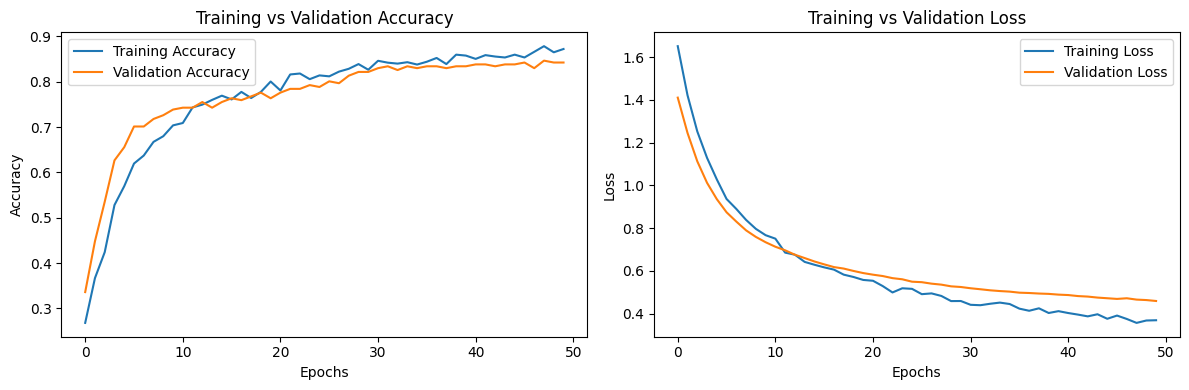

In [44]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
model.save("AIDermalScan_MobileNetV2_Final.h5")
print("saved")


saved
